# Исследование данных интернет-магазина игр

Международный интернет-магазин "Стримчик", занимается продажей компьютерных игр. Перед нами исторические данные из открытых источников, включающие в себя информацию о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Перед нами стоит задача: выявить закономерности, определяющие успешность игры, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Нам доступны данные до 2016 года.

Описание данных:

- `Name` — название игры
- `Platform` — платформа
- `Year_of_Release` — год выпуска
- `Genre` — жанр игры
- `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
- `EU_sales` — продажи в Европе (миллионы проданных копий)
- `JP_sales` — продажи в Японии (миллионы проданных копий)
- `Other_sales` — продажи в других странах (миллионы проданных копий)
- `Critic_Score` — оценка критиков (максимум 100)
- `User_Score` — оценка пользователей (максимум 10)
- `Rating` — рейтинг от ассоциации ESRB (англ. Entertainment Software Rating Board). Согласно данному рейтингу определяются возрастные ограничения, игре присваивается возрастная категория.

## Откроем файл с данными и изучим общую информацию.
Импортируем необходимые библиотеки, считываем данные из csv-файла в датафрейм и сохраняем в переменную data.

In [2]:
import pandas as pd
import seaborn as sns
import pylab as pl
import numpy as np
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.ticker import FuncFormatter
from scipy import stats as sts



In [3]:
try:
    data = pd.read_csv('datasets/games.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

Выведем первые 10 строчек датафрейма data на экран

In [4]:
data.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Выведем основную информацию о датафрейме:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


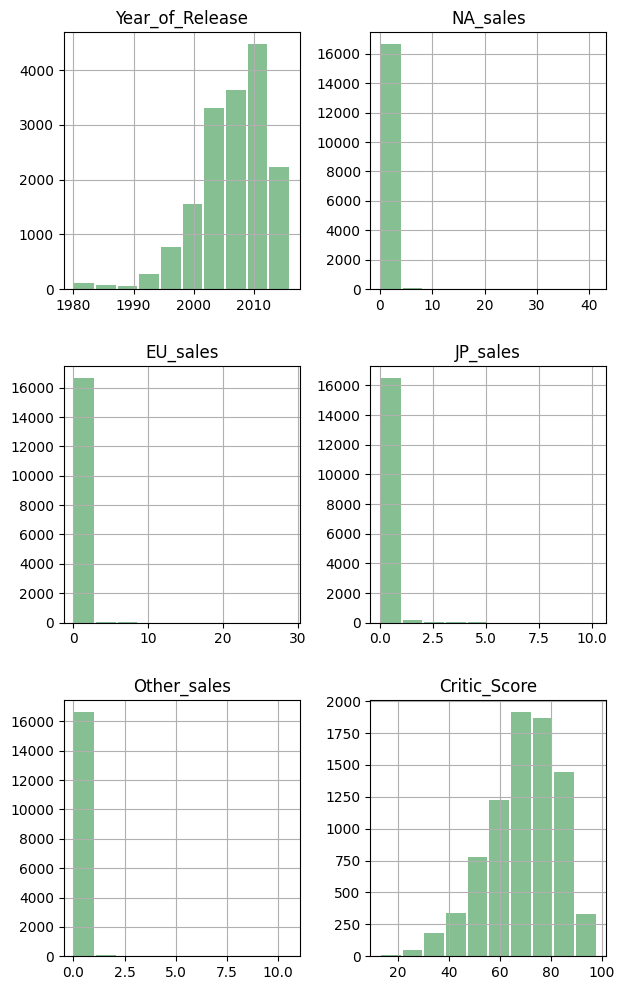

In [6]:
data.hist(figsize=(7, 12), color='#86bf91', rwidth=0.9);

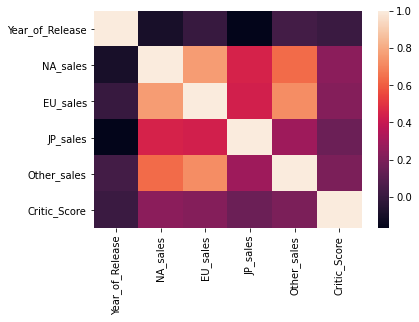

In [6]:
sns.heatmap(data.corr());

`В датафрейме 11 столбцов и 16715 строк, в некоторых встречаютя пропуски.` В последующих шагах заменим пропуски, где это необходимо. Кроме того, `измененим тип данных` в столбцах: год выпуска *(float->int)*, оценки пользователей *(object->float)*. И займемся более детальным изучением корреляции факторов, влияющих на успешность игры.

*Займемся предобработкой данных:*

## Предобработка данных

Поменяем стиль заголовков:

In [7]:
# перечень названий столбцов таблицы data 
print(data.columns) 

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')


In [8]:
# приведем названия столбцов к нижнему регистру
data.columns = data.columns.str.lower()
# проверим, как изменились названия
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Приведем к нижнему регистру столбцы `'name','platform','genre','rating'` этим же шагом избавимся от возможных дубликатов (связанных с регистром)

In [9]:
for column in data[['name','platform','genre','rating']]:
    data[column] = data[column].str.lower()

Определим количество пропущенных значений в каждом столбце:

In [10]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Определим процентное соотношение пропусков в каждом столбце:

In [11]:
data_pct =[]
data_pct_name = []
for col in data:
    pct = np.mean(data[col].isnull()) 
    data_pct_name.append(col)
    data_pct.append(pct*100)

df_pct = pd.DataFrame(data_pct, index = data_pct_name, columns = ['%'])

In [12]:
df_pct.style.background_gradient(cmap = 'PuBu', text_color_threshold = 0.48,\
                                 vmin = 0.00001, vmax = 0.0001, axis=0)

,%
name,0.011965
platform,0.000000
year_of_release,1.609333
genre,0.011965
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.319174
user_score,40.089740


In [13]:
data.shape

(16715, 11)

Займемся обработкой пропусков:

в столбцах `name` и `genre` из 16715 строк в 2 встречаются пропуски (много меньше 1%), поэтому строки с пропусками в названии игры и названии жанра можем удалить.  

In [14]:
data = data.dropna(subset=['name','genre'])

In [15]:
data.shape # во избежание ошибок, проверим, сколько строк удалилось

(16713, 11)

Аналогично для столбца `year_of_release` 269 пропусков, относительно нашего датафрейма это меньше 1%. Кроме того, встречаются столбцы, где пропущен не только год выспуска, но и показатели оценки критиков, пользователей, а так же рейтинг. При заполнении выше перечисленных столбцов синтетическими значениями (например, медианой или средним) увеличивается риск искажения результатов исследования. Поэтому на данном этапе удалим строки с пропусками в столбце `year_of_release`

In [16]:
data.loc[data['year_of_release'].isnull()].head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,madden nfl 2004,ps2,NaN,sports,4.26,0.26,0.01,0.71,94.0,8.5,e
377,fifa soccer 2004,ps2,NaN,sports,0.59,2.36,0.04,0.51,84.0,6.4,e
456,lego batman: the videogame,wii,NaN,action,1.80,0.97,0.00,0.29,74.0,7.9,e10+
475,wwe smackdown vs. raw 2006,ps2,NaN,fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,space invaders,2600,NaN,shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


In [17]:
data = data.dropna(subset=['year_of_release'])
data.shape # во избежание ошибок, проверим, сколько строк удалилось

(16444, 11)

Остались пропуски в столбцах:`critic_score`, `user_score`, `rating`.
Начнем с рейтинга


In [18]:
data['rating'].unique() # определим уникальные значения столбца

array(['e', nan, 'm', 't', 'e10+', 'k-a', 'ao', 'ec', 'rp'], dtype=object)

In [19]:
data['rating'].value_counts()

e       3921
t       2905
m       1536
e10+    1393
ec         8
k-a        3
rp         1
ao         1
Name: rating, dtype: int64

- «EC» («Early childhood») — «Для детей младшего возраста»
- «E» («Everyone») — «Для всех»`Первоначально "K-A" ("Kids to Adults")` **поэтому можем играм с рейтингом k-a присвоить рейтинг e**
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
- «T» («Teen») — «Подросткам»
- «M» («Mature») — «Для взрослых»
- «AO» («Adults Only 18+») 
- «RP» («Rating Pending») — «Рейтинг ожидается»

In [20]:
# k-a = e 
data['rating'] = data['rating'].replace({'k-a':'e'}) 

In [21]:
data['rating'].isna().sum() # количество пропускоы в столбце

6676

За счет устранения пропусков в уже обработанных столбцах, количество пропущенных значений в столбце `rating` уменьшилось, рассчитаем долю пропусков:

In [22]:
data['rating'].isna().mean() # доля

0.40598394551204087

Для исследования того, как отсутствие рейтинга игры влияет на покупательские способности, заменим пропуски в столбцах с указанием рейтинга на `no_rating`, так как пропуски в данном столбце могли появиться по причине отсутствия такового у некоторых игр. 

*Ассоциации ESRB (англ. Entertainment Software Rating Board), присваивающая возраствую категорию, была основана в 1994 году, и не всем играм, выпущенным ранее(до 1994 года), был присвое рейтинг.*


In [23]:
data['rating'] = data['rating'].fillna('no_rating')
data.shape # во избежание ошибок, проверим, количество строк и столбцов

(16444, 11)

Перейдем к пропускам в столбцах: `user_score`, `critic_score`

In [24]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В столбце с оценкой пользователей встречается аббревиатура `'tbd'`, что значит `'To Be Determined' - 'Будет определено'`. Следовательно `'tbd'` = неизвестное значение, `меняем на 'NaN'`.

In [25]:
data['user_score'] = data['user_score'].replace('tbd', np.nan, regex=True)
data['user_score'].isna().mean() # определим долю пропусков в столбце

0.5461566528825104

In [26]:
data['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

Градация оценок критиков для видеоигр обычно от 0 - 10, приведем значения стоблца в привычный вид

In [27]:
data['critic_score'] = data['critic_score'] * 0.1
data['critic_score'].unique()

array([7.6, nan, 8.2, 8. , 8.9, 5.8, 8.7, 9.1, 6.1, 9.7, 9.5, 7.7, 8.8,
       8.3, 9.4, 9.3, 8.5, 8.6, 9.8, 9.6, 9. , 8.4, 7.3, 7.4, 7.8, 9.2,
       7.1, 7.2, 6.8, 6.2, 4.9, 6.7, 8.1, 6.6, 5.6, 7.9, 7. , 5.9, 6.4,
       7.5, 6. , 6.3, 6.9, 5. , 2.5, 4.2, 4.4, 5.5, 4.8, 5.7, 2.9, 4.7,
       6.5, 5.4, 2. , 5.3, 3.7, 3.8, 3.3, 5.2, 3. , 3.2, 4.3, 4.5, 5.1,
       4. , 4.6, 3.9, 3.4, 4.1, 3.6, 3.1, 2.7, 3.5, 2.6, 1.9, 2.8, 2.3,
       2.4, 2.1, 1.7, 1.3])

In [28]:
data['critic_score'].isna().mean() # определим долю пропусков в столбце

0.5145341765993675

В столбцах с оценками более 50% пропущенных ячеек. 
Что, вероятно, связанос тем, что пользователи не всегда охотно оставляют оценки, а для получение оценки критиков - платная процедура и разработчики не всегда на это идут.

Поэтому: заменить пропуски синтетическими значениями мы не можем, удалить значения с пропусками тоже, это повлияет на анализ,  заменим пропущенные значения в обоих столбцах маркером (например -1, значением, не встречающемся в столбцах)

In [29]:
data['user_score'] = data['user_score'].fillna(-1)
data['critic_score'] = data['critic_score'].fillna(-1)
data.shape # во избежание ошибок, проверим, количество строк и столбцов

(16444, 11)

**Важно!** `в дальнейших шагах: при построении графиков, определении корреляции индикаторные значения исключаем`

Преобразуем данные столбцов `year_of_release` и `user_score` в нужные типы. 
- год выпуска - целое число, меняем  *float -> int* 
- оценки пользователей меняем на вещественный тип *object -> float*

In [30]:
# меняем типы данных столбцов 
data['year_of_release'] = np.floor(pd.to_numeric\
                                 (data['year_of_release'], errors='coerce')).astype('Int64')
data['user_score'] = np.floor(pd.to_numeric\
                                 (data['user_score'], errors='coerce')).astype('float64')

Посчитаем суммарные продажи во всех регионах и запишите их в новый, отдельный столбец `total_sales`.

In [31]:
data['total_sales'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1) 

Еще раз проверим количество пропусков в данных:

In [32]:
data.isna().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
total_sales        0
dtype: int64

**Пропуски устранены.**

Проверим наличие `дубликатов`:

In [33]:
# посчитаем явные дубликаты в датафрейме
data.duplicated().sum()

0

In [34]:
# посчитаем неявные дубликаты, с совпадениями в имени, плотформе и году выпуска 
data.duplicated(subset=['name','platform', 'year_of_release'],keep=False).sum()

2

обнаружено всего 2 дубликата, они не повлияют на результаты анализа

**`Данные подготовлены к дальнейшему анализу:`**
- изменили формат сстолбцов
- обработали пропуски (*в столбцах name, year_of_release, genre  пропуски были удалены в виду небольшого количества, данный шаг не влияет на результаты исследования*)
- там, где это возможно, заменили пропущенные значения(*в столбцах critic_score и user_score более 50% значний пропущены, заменили пропуски на маркеры*)
- определили вероятные причины пропусков данных
- добавили столбец с суммарными продажами во всех регионах
- определили дубликаты в таблице

## Исследовательский анализ данных

Выясним, сколько игр выпускалось в разные годы:

In [35]:
data.groupby('year_of_release').agg({'name': 'count'})\
.sort_values('year_of_release', ascending=False)

,name
year_of_release,
2016,502
2015,606
2014,581
2013,544
2012,653
2011,1136
2010,1255
2009,1426
2008,1427


Для наглядности построим график распределения продаж видеоигр по годам:

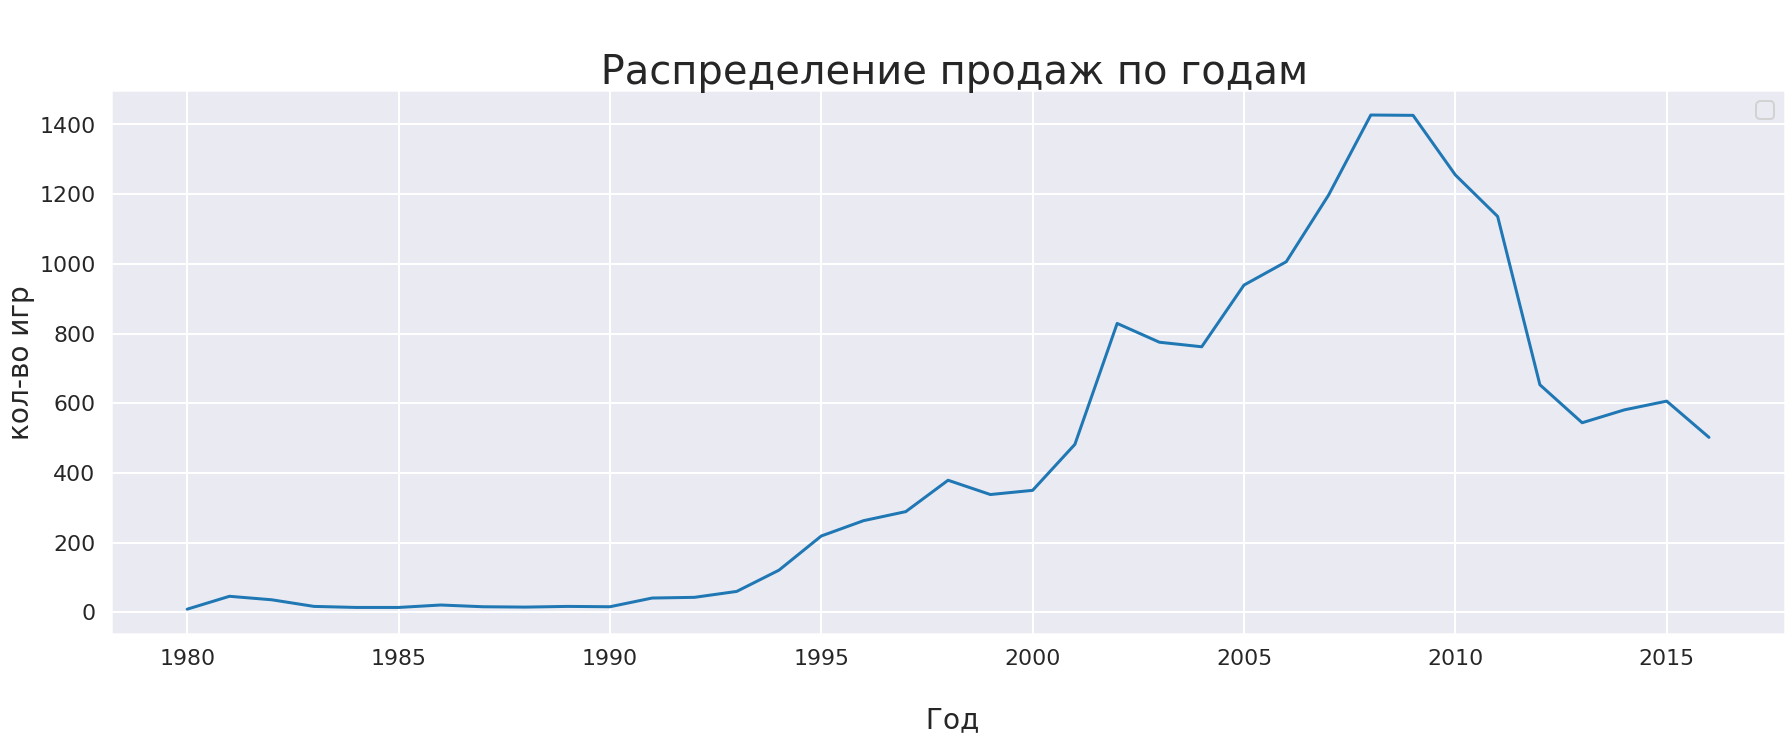

In [36]:
sns.set_style('darkgrid')
sns.set_context('poster')
games_by_year = data.pivot_table(index='year_of_release', values='name', aggfunc='count')
plt.figure(figsize=(30,10))
sns.lineplot(data=games_by_year)
plt.title('\n Распределение продаж по годам', size=40)
plt.xlabel('\n Год', size=28)
plt.ylabel('кол-во игр', size=28)
plt.legend('');

С 1980-1993 количество проданных игр в год  исчислялось в десятках, с 1994 года наблюдаем заметный рост продаж, с скачком в 2002 году и максимальным значением в 2008-2009 годы, после количество продаж видеоигр снова идет на спад. 

Наиболее важными для нас являются данные с 2000 года, именно в этом периоде мы определили значительное развитие рынка видеоигр. 

`Посмотрим, как менялись продажи по платформам:`
Выделим платформы с наибольшими суммарными продажами:

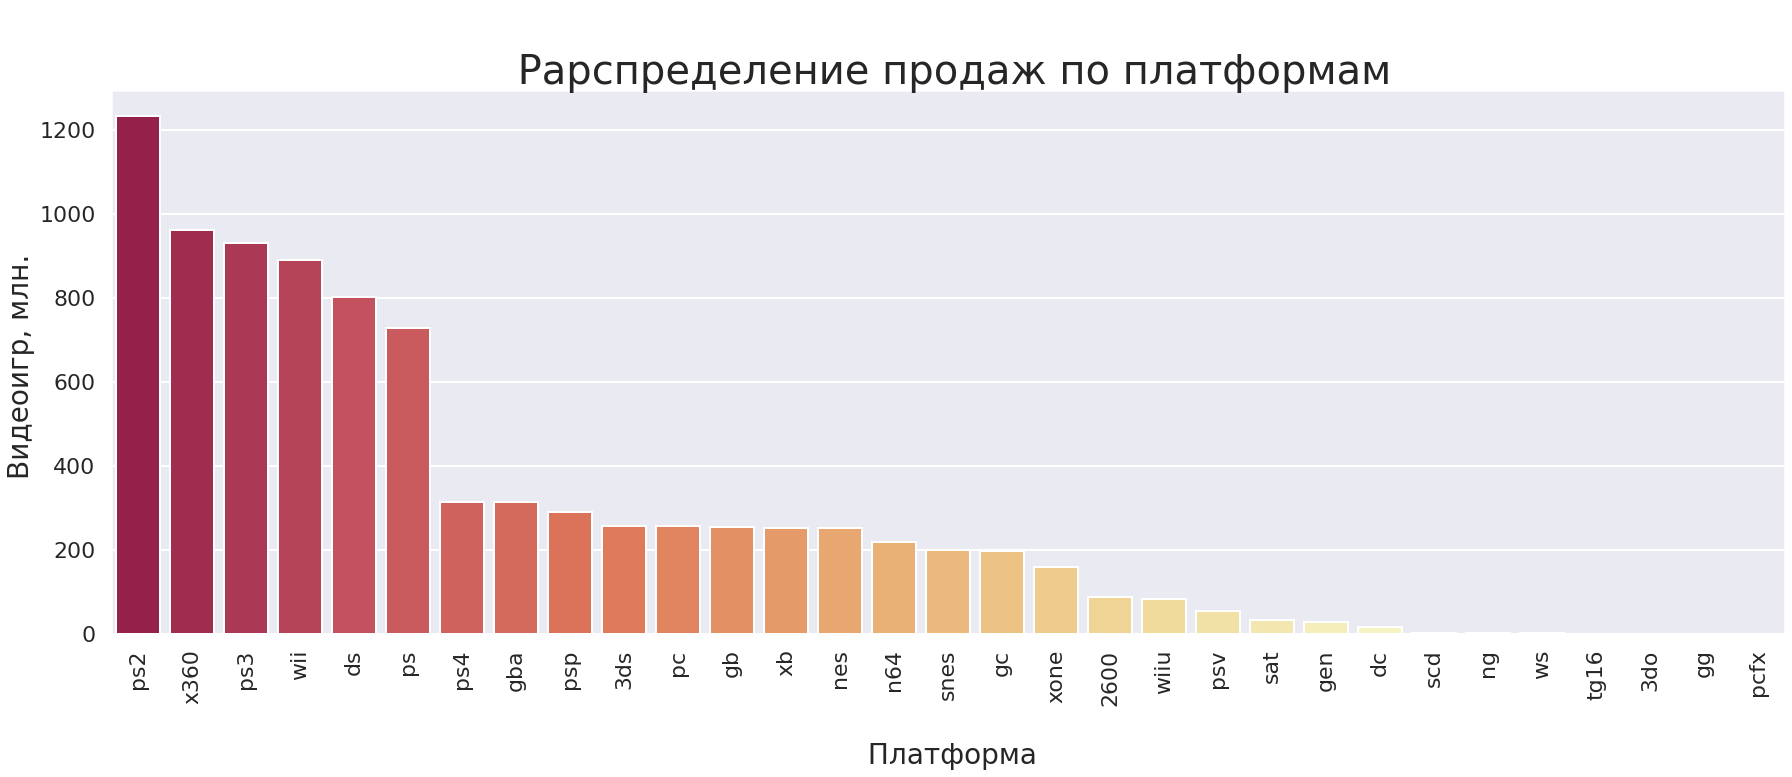

In [37]:
# Построим график распределения продажи игр по платформам
sns.set_style('darkgrid')
plt.figure(figsize=(30, 10))
top = data.pivot_table(index='platform', values='total_sales', aggfunc='sum')\
.sort_values(by='total_sales', ascending=False)
sns.barplot(x = top.index, y = top['total_sales'],\
            palette=sns.color_palette("Spectral", 48))
plt.xticks(rotation = 90)
plt.title('\n Рарспределение продаж по платформам', size=40)
plt.xlabel('\n Платформа', size=28)
plt.ylabel('Видеоигр, млн. ', size=28);


In [38]:
# выборем 6 платформ с наибольшими суммарными продажами
top_platforms = top[:6].index.tolist()
top_platforms 

['ps2', 'x360', 'ps3', 'wii', 'ds', 'ps']

`Построим распределение по годам:`

In [ ]:
# как мы уже определили ранее, значимым для нашего анализа является отрезок времени с начала 2000

data_2000 = data[data['year_of_release']>=2000]
dt = []
for platform in top_platforms:
    dt.append(
        go.Bar(x=data_2000[data_2000.platform==platform].groupby("year_of_release")\
               ['total_sales'].sum().index, 
               y=data[data.platform==platform].groupby("year_of_release")\
               ['total_sales'].sum(),
               name=platform)
              )

fig = go.Figure(data=dt, layout={'title': 'Распределение продаж по годам - топ 6 платформ'}, skip_invalid=True)
fig.show()

Мы визуализировали `распределение продаж видеоигр на 6 самых популярных платформах по годам`. 

Как заметно из графика - платформы появляются, постепенно набирают популярность, а после, замещаются более современными игровыми консолями. Исходя из графика, видно, что этот процесс занимает около `10 лет`, затем приставки устаревают, игры выпускают и продают уже на новые модели.

Для прогноза на 2017 год, `актуальным периодом для нас будет 2006-2016 гг.` Данные за предыдущие годы можем не учитывать. 

In [ ]:
# для прогноза на 2017 актуальными будут данные за период с 2014-2016 года 
data_2014 = data[data['year_of_release']>=2014]
dt = []
for platform in top_platforms:
    dt.append(
        go.Bar(x=data_2014[data_2014.platform==platform].groupby("year_of_release")\
               ['total_sales'].sum().index, 
               y=data[data.platform==platform].groupby("year_of_release")\
               ['total_sales'].sum(),
               name=platform)
              )

fig = go.Figure(data=dt, layout={'title': 'Распределение продаж по годам - топ 6 платформ'}, skip_invalid=True)
fig.show()

Определим, какие платформы лидируют по продажам.

In [ ]:
df = []
# начиная с 2006 года выведем распределение количества игр на различных платформах
for platform in data_2014['platform'].unique():
    df.append(
        go.Scatter(x=data_2014[data_2014.platform==platform]\
                   .groupby("year_of_release")['total_sales'].sum().index,
               y=data_2014[data_2014.platform==platform]\
                   .groupby("year_of_release")['total_sales'].sum(),
               name=platform)
    )

    
fig = go.Figure(data=df,\
                layout={'title': \
                        'Распределение продаж млн.шт. видеоигр на различных платформах c 2014-2016гг.'})
fig.show()

К 2016 году продажи видеоигр на всех платформах падают, наиболее прибыльными на интересующий нас момент являются `ps4 с продажами 69.25 млн. экзкмпляров` в 2016, `xone - 26.16 млн. экзкмпляров`, `3dc - 15.14 млн. экзкмпляров`, `pcv - 4.25млн. экзкмпляров`. Кроме того четко прослеживается заметное падение к 2013 году и в том же году появляются игры на платформах ps4 и xb. Сузим актуальный период для прогноза на 2017 год до 3 предыдущих лет.

Построим график по глобальным продажам игр в разбивке по платформам:

In [ ]:
df = []

for platform in data_2014['platform'].unique():
    df.append(go.Box(y=data_2013[data_2013.platform==platform]['total_sales'],\
               name=platform ))
    
fig = go.Figure(data=df, layout={'title': 'График глобальных продаж игр в разбивке по платформам'})
fig.update_layout(yaxis=dict(range=[0, 4.5])) 


Наибольшая медиана продаж в интересующем нас периоде у платформы `x360 (равно 0.265)`, далее следует `xone (медиана 0.22)`, следом за ней с небольшим отрывом `ps4 и wiiu (медиана 0.2)`. Отметим, что в данных встречается достаточно много выбивающихся значений, что связано с большей популярностью какой-то определенной игры, относительно остальных.

**На основании данных одной платформы** (выберем `x360`, так как у нее самая высокая медиана продаж с 2013-2016гг.) **определим, как влияют на продажи отзывы пользователей и критиков:**

Построим диаграмму рассеяния.

In [ ]:
# обращаем внимание на значения-маркеры, которыми мы заполнили пропуски в столбцах с отзывами
# исключим эти значения из анализа
x360_score = data_2013.query('platform == "x360"')

x360_score[x360_score['critic_score'] != -1].plot(kind='scatter', x='critic_score',\
        y='total_sales', color='orange')
plt.xlabel('Оценка критиков', fontsize=15)
plt.ylabel('Общие продажи', fontsize=15)
plt.title('Зависимость продаж от оценки критиков плотформы x360', fontsize=18)

x360_score[x360_score['user_score'] != -1].plot(kind='scatter', x='user_score',\
        y='total_sales', color='forestgreen')
plt.xlabel('Оценка пользователей', fontsize=15)
plt.ylabel('Общие продажи', fontsize=15)
plt.title('Зависимость продаж от оценки пользователей плотформы x360', fontsize=18);




**Посчитаем корреляцию между отзывами и продажами:**

In [ ]:
x360_score[(x360_score['critic_score'] != -1) & (x360_score['user_score'] != -1)]\
 [['critic_score', 'user_score', 'total_sales']].corr()

Наблюдаем слабую положительную корреляцию между оценками критиков и общими продажами, а так же между оценками критиков и оценками пользователей. При этом, оценки пользователей с продажами не коррелируют.

Соотнесем полученные результаты с продажами игр на других платформах:

In [ ]:
for platform in ['ps4', 'xone', 'wiiu']:
    print('\n{0}:'.format(platform))
    for column in ['user_score', 'critic_score']:
        temp = data_2013.query('platform == platform and user_score >= 0 & critic_score >= 0')
        print('{0} и total_sales: {1}'.\
              format(column, round(temp[column]).corr(temp['total_sales']), 2))


Аналогично предыдущему замечанию: наблюдаем слабую положительную связь между оценкой критиков и продажами, оценки пользователей, при этом, не коррелируют с объемом продаж. 

**Определим, как распределяются игры по жанрам:**

In [ ]:
pt_genre = data_2013.pivot_table(index = ['genre'], values = 'total_sales',\
    aggfunc = 'mean').reset_index().sort_values(by = 'total_sales',ascending = False)

plt.figure(figsize=(24, 10))
sns.set(style="darkgrid")
sns.barplot(x = pt_genre['genre'], y = pt_genre['total_sales'])
plt.xlabel('Жанры', fontsize=20)
plt.ylabel('Общие продажи', fontsize=20)
plt.title('Зависимость уровня продаж от жанра', fontsize=35);


Согласно распределению, за актуальный период, самым прибыльным жанром является `shooter`, следующий по доходности жанр с объемом продаж меньшим практически в 2 раза  - `sports`, за ним следуют `platform`и `role-playing`. Самый низкий уровень продаж у игр жанва `adventure`.

**Нами был проведен исследовательский анализ данных:**
- Выяснили, какое количество игр выпускалось в разные годы. С 1980-1993 количество проданных игр в год  исчислялось в десятках, с 1994 года наблюдаем заметный рост продаж, с скачком в 2002 году и максимальным значением в 2008-2009 годы, после количество продаж видеоигр снова идет на спад. 
- Определили, что с 2000 года происходило значительное развитие рынка видеоигр. 
- Выделим платформы с наибольшими суммарными продажами:
- Визуализировали распределение продаж видеоигр на 6 самых популярных платформах по годам. Заметили, что  платформы появляются, постепенно набирают популярность, а после, замещаются более современными игровыми консолями. Данный процесс занимает около 10 лет, затем приставки устаревают, а игры выпускают и продают уже на новые модели.
- Определили актуальный период для прогноза на 2017 год: нас это 2006-2016 гг. Данные за предыдущие годы можем не учитывать. 
- Узнали, какие платформы лидируют по продажам. К 2016 году продажи видеоигр на всех платформах падают, наиболее прибыльными на интересующий нас момент являются ps4 с продажами 69.25 млн. экзкмпляров в 2016, xone - 26.16 млн. экзкмпляров, 3dc - 15.14 млн. экзкмпляров, pcv - 4.25млн. экзкмпляров. Кроме того четко прослеживается заметное падение к 2013 году и в том же году появляются игры на платформах ps4 и xb. Сузили актуальный период для прогноза на 2017 год до 3 предыдущих лет.
- Построили график продаж игр в разбивке по платформам: Наибольшая медиана продаж в интересующем нас периоде у платформы x360 (равно 0.265), далее следует xone (медиана 0.22), следом за ней с небольшим отрывом ps4 и wiiu (медиана 0.2). Отметим, что в данных встречается достаточно много выбивающихся значений, что связано с большей популярностью какой-то определенной игры, относительно остальных.
- Определили влияние на продажи отзывов пользователей и критиков: наблюдается слабая положительная корреляцию между оценками критиков и общими продажами, а так же между оценками критиков и оценками пользователей. При этом, оценки пользователей с продажами не коррелируют.

## Составление портрета пользователя каждого региона

`Выделим топ-5 самых популярных платформ по регионам за актуальный период:`

In [ ]:
# топ-5 в Северной Америке
na_platform = data_2013.groupby('platform')['na_sales'].sum().sort_values(ascending=False)[:5]
# топ-5 в Европе
eu_platform = data_2013.groupby('platform')['eu_sales'].sum().sort_values(ascending=False)[:5]
# топ-5 в Японии
jp_platform = data_2013.groupby('platform')['jp_sales'].sum().sort_values(ascending=False)[:5]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
plt.suptitle('Распределение топ-5 самых популярных платформ по регионам:', y=1.08, fontsize=20)

ax1.bar(na_platform.index.tolist(), na_platform)
ax1.set_title("Северная Америка", fontsize=18)

ax2.bar(eu_platform.index.tolist(), eu_platform)
ax2.set_title("Европа", fontsize=18)

ax3.bar(jp_platform.index.tolist(), jp_platform)
ax3.set_title("Япония", fontsize=18)

plt.show()

Как видно из графиков: лидирующую позицию в Северной Америке и Европе за последние 3 года, занимает ps4, в то время, как в Японии данная платформа лишь на 4 месте по популярности, самая популярная 3ds. Любопытно заметить, что в NA и EU 3ds лишь на 5 месте, отметим, что топ-5 рейтинги этих регионов представлены одними и теми же платформами, в то время, как из 5 самых популярных платформ JP 2 позиции отличаются от выбора европейцев и североамериканцев. 

Остановимся на различиях в долях продаж игр на 5 самых популярных платформах каждого региона:

В **Северной Америке** четверть продаж приходится на ps4, остальные платформы расположились с небольшим, примерно одинаковым отрывом друг от друга - xone, x360, ps3 и 3ds соответственно.

В **Европе** около 40% продаж игр на платформе ps4, на втором месте примерно на 20% продаж приходится на игры платформы ps3, далее с небольшим отрывом между собой следуют: xone, x360 и 3ds.

В **Японии** картина кардинально меняется: половина продаж на платформе 3ds, примерно пятая часть за вторым местом,- ps3, далее с небольшим отрывом psv (не попавшая в топ 5 предыдущих регионов), затем ps4 и wiiu(так же не вошедшая в рейтинг самых популярных платформ Северной Америки и Европы).


`Определим, как отличаются рейтинги 5 самых популярных жанров по регионам:`

In [ ]:
# топ-5 в Северной Америке
na_genre = data_2013.groupby('genre')['na_sales'].sum().sort_values(ascending=False)[:5]
# топ-5 в Европе
eu_genre = data_2013.groupby('genre')['eu_sales'].sum().sort_values(ascending=False)[:5]
# топ-5 в Японии
jp_genre = data_2013.groupby('genre')['jp_sales'].sum().sort_values(ascending=False)[:5]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
plt.suptitle('Распределение топ-5 самых популярных жанров по регионам:', y=1.08, fontsize=20)
ax1.bar(na_genre.index.tolist(), na_genre, color='darksalmon')
ax1.set_title("Северная Америка", fontsize=18)

ax2.bar(eu_genre.index.tolist(), eu_genre, color='darksalmon')
ax2.set_title("Европа", fontsize=18)

ax3.bar(jp_genre.index.tolist(), jp_genre, color='darksalmon')
ax3.set_title("Япония", fontsize=18)

plt.show()

Распределения топ-4 самых популярных видеоигр по жанрам в Северной Америке и Европе совпсовпадают: на первом месте жанр action, затем shooter, после sports и role-playing, на пятом месте в NA misc, а в EU - racing.

В то время, как в Японии самым популярным жанром стал role-playing (четвертый по популярности в выше описаных регионах), за ним следует action - лидер в NA и EU, затем misc, fighting  и shooter соответственно.

`Определим, влияет ли рейтинг ESRB на продажи в каждом регионе:`

In [ ]:
for region in ['eu_sales', 'na_sales', 'jp_sales']:
    plt.figure(figsize = (20,5))
    
    region_ersb = data_2013.pivot_table(index = 'rating', values = region,\
                aggfunc = 'sum').sort_values(by = region, ascending = False).reset_index()    
    sns.barplot(data = region_ersb, x = 'rating', y = region)
    plt.xlabel('Рейтинг', fontsize=18)
    plt.ylabel('Продажи', fontsize=18)
    if region == 'eu_sales':
        plt.title('Европа', fontsize=23)
    elif region == 'na_sales':
        plt.title('Северная Америка', fontsize=23)
    else: plt.title('Япония', fontsize=23)
    plt.show()

Как описывалось ранее:
- «EC» («Early childhood») — «Для детей младшего возраста»
- «E» («Everyone») — «Для всех»`Первоначально "K-A" ("Kids to Adults")` 
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
- «T» («Teen») — «Подросткам»
- «M» («Mature») — «Для взрослых»
- «AO» («Adults Only 18+») 
- «RP» («Rating Pending») — «Рейтинг ожидается»
- «no_rating» - видеоигры без рейтинга


В Европе и Северной Америке лидируют продажи игр с рейтингом «M» («Mature») — «Для взрослых», а в Японии лучше продаются игры без рейтинга, что, вероятно связано с популярностью в Японии игр на 3ds.

## Проверка гипотез

### Проверим гипотезы:


**H0:** 
`среднее значение генеральной совокупности PC `**`равно`**` среднему значению генеральной совокупности Xbox One`


**H1:** 
`среднее значение генеральной совокупности PC `**`не равно`**` среднему значению генеральной совокупности Xbox One`


*при уровне статистической значимости 0.05*

In [ ]:
xone_sample = data_2013.query('platform == "xone" and user_score != -1')['user_score']
ps_sample = data_2013.query('platform == "pc" and user_score != -1')['user_score']

alpha = .05 # уровень статистической значимости
results = sts.ttest_ind(xone_sample, ps_sample, equal_var=False)

print('p-значение:', results.pvalue.round(2))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    

**Нулевая гипотеза не отвергнута, а значит, средние пользовательские рейтинги платформ Xbox One и PC равны.**

### Проверим гипотезы:


**H0:** 
`Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования»)`**`равны`** 


**H1:** 
`Средние пользовательские рейтинги жанров Action и Sports `**`разные`**

*при уровне статистической значимости 0.05*

In [ ]:
action = data_2013.query('genre == "action" and user_score != -1')['user_score']
sports = data_2013.query('genre == "sports" and user_score != -1')['user_score']


results_2 = sts.ttest_ind(action, sports, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

**Нулевая гипотеза не отвергнута, следовательно, средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») не отличаются**

Для проверки гипотез мы использовали двусторонний тест.

Существует два типа проверки гипотез:
Односторонний тест : альтернативная гипотеза содержит знак < или >
Двусторонний тест : альтернативная гипотеза содержит знак ≠

В сформулированных нами гипотезах, альтернативная имеет знак ≠, следовательно целесообразно применять именно двусторонний тест. Мы проверяем, существует ли какой-либо эффект, независимо от того, положительный он или отрицательный.

## Вывод

**Для оценки закономерностей, влияющих на успешность игры, было проведено исследование.
Результаты, полученные из анализа позволят сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.**

В ходе проведения анализа, мы выяснили что с начала 90-х и до 2009 года количество игр стремительно увеличивалось, после 2009 количество продаж видеоигр снова идет на спад, что, вероятно, связано с развитием мобильных приложений. После визуализации распределния продаж видеоигр на 6 самых популярных платформах по годам. Заметили, что платформы появляются, постепенно набирают популярность, а после, замещаются более современными игровыми консолями. Данный процесс занимает около 10 лет, а "пик" продаж наступает через 5 лет, затем приставки устаревают, а игры выпускают и продают уже на новые модели.


Определили актуальный период для прогноза на 2017 год: нас это 2006-2016 гг. 
К 2016 году продажи видеоигр на всех платформах падают, наиболее прибыльными на интересующий нас момент являются ps4 с продажами 69.25 млн. экзкмпляров в 2016, xone - 26.16 млн. экзкмпляров, 3dc - 15.14 млн. экземпляров, pcv - 4.25млн. экзкмпляров. Кроме того четко прослеживается заметное падение к 2013 году и в том же году появляются игры на платформах ps4 и xb. Сузили актуальный период для прогноза на 2017 год до 3 предыдущих лет(2013-2017гг).

Построили график продаж игр в разбивке по платформам: наибольшая медиана продаж в интересующем нас периоде у платформы x360 (равно 0.265), далее следует xone (медиана 0.22), следом за ней с небольшим отрывом ps4 и wiiu (медиана 0.2). Отметим, что в данных встречается достаточно много выбивающихся значений, что связано с большей популярностью какой-то определенной игры, относительно остальных.
Определили влияние отзывов пользователей и критиков на продажи: наблюдается слабая положительная корреляция между оценками критиков и общими продажами, а так же между оценками критиков и оценками пользователей. При этом, оценки пользователей с продажами не коррелируют. Что указывает на то, что для пользователей не играют значимой роли оценки других пользователей, в то время, как положительные оценки критиков заставляют задуматься о покупке.

Согласно распределению, за актуальный период, самым прибыльным жанром является shooter, следующий по доходности жанр с объемом продаж меньшим практически в 2 раза - sports, за ним следуют platformи role-playing. Самый низкий уровень продаж у игр жанра adventure.

Так же нами были составлены **портреты пользователей** каждого региона:

- Самые популярные `игровые платформы` в **`Северной Америке`**: `ps4, xone, x360, ps3` и `3ds`.    `Топ 5 жанров`: action, shooter, sports, platform, misc. Лидируют продажи игр с `рейтингом` **«M»** *(«Mature») — «Для взрослых»*, на втором месте игры с рейтингом **«E»** («Everyone») — «Для всех» и на третьем месте игры без рейтинга.

- Самые популярные `игровые платформы` в **`Европе`**: `ps4, xone, x360` и `3ds`.                   `Топ 5 жанров`: action, shooter, sports, platform, racing. Лидируют продажи игр с `рейтингом` **«M»** *(«Mature») — «Для взрослых»*, на втором месте игры с неизвестным рейтингом, на третьем - с  рейтингом **«E»** («Everyone») — «Для всех».

- Самые популярные `игровые платформы` в **`Японии`**: `3ds, ps3, psv, ps4` и `wiiu`. `Топ 5 жанров`: role-playing, action, misc, fighting, shooter. Лидируют продажи игр с неизвестным `рейтингом`, на втором месте игры с рейтингом **«Т»** *(«Teen») — «Подросткам»*, на третьем - с  рейтингом **«E»** («Everyone») — «Для всех».


Следовательно, по нашим рассчетам, в **2017 году больше прибыли будут приносить игры** жанра `shooter`, для платформы `PS4` с рейтингом `"для взрослых"`. На втором месте по продажам разместятся игры того же жанра, для платформы `PS4` и с рейтингом `"для всех"`. Так же прибыльньными будут актуальные по большей мере для пользователей из `Японии`, видеоигры жанра `role-playing` на платформе `3ds`.
`Самый низкая доходность предполагается у игр жанра adventure.`
